<a href="https://colab.research.google.com/github/meovvmiao/AIPI-590-XAI/blob/main/adversarial_patch/adversarial_attacks_patches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #Adversarial Patches
### Eleanor Jiang


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meovvmiao/aipi-590-xai/blob/adversarial_patch_adversarial_attacks_patches.ipynb)


In [41]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI-590-XAI" # Change to your repo name
git_path = 'https://github.com/meovvmiao/AIPI-590-XAI.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'adversarial_patch'
# path_to_notebook = os.path.join(repo_name,notebook_dir)
path_to_notebook = os.path.join(repo_name, notebook_dir)
%cd "{path_to_notebook}"
%ls

rm: cannot remove './sample_data': No such file or directory
Cloning into 'AIPI-590-XAI'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 98 (delta 25), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (98/98), 6.65 MiB | 14.05 MiB/s, done.
Resolving deltas: 100% (25/25), done.
/content/AIPI-590-XAI/explainable_deep_learning/AIPI-590-XAI/adversarial_patch/AIPI-590-XAI/adversarial_patch/AIPI-590-XAI/adversarial_patch
1.txt  adversarial_attacks_patches.ipynb


Below is a copy of example notebook.

# Copy of example notebook

In [42]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

/tmp/ipython-input-1779675758.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cpu


In [43]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

Unzipping file...
Unzipping file...


## Setup

For our experiments in this notebook, we will use common CNN architectures trained on the ImageNet dataset. Such models are luckily provided by PyTorch's torchvision package, and hence we just need to load the model of our preference. For the results on the website and default on Google Colab, we use a ResNet34. Feel free to experiment with other architectures as well, the code is mainly independent of the specific architecture we choose.

In [44]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to ../saved_models/tutorial10/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 116MB/s]


To perform adversarial attacks, we also need a dataset to work on. Given that the CNN model has been trained on ImageNet, it is only fair to perform the attacks on data from ImageNet. For this, we provide a small set of pre-processed images from the original ImageNet dataset (note that this dataset is shared under the same [license](http://image-net.org/download-faq) as the original ImageNet dataset). Specifically, we have 5 images for each of the 1000 labels of the dataset. We can load the data below, and create a corresponding data loader.

In [45]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Before we start with our attacks, we should verify the performance of our model. As ImageNet has 1000 classes, simply looking at the accuracy is not sufficient to tell the performance of a model. Imagine a model that always predicts the true label as the second-highest class in its softmax output. Although we would say it recognizes the object in the image, it achieves an accuracy of 0. In ImageNet with 1000 classes, there is not always one clear label we can assign an image to. This is why for image classifications over so many classes, a common alternative metric is "Top-5 accuracy", which tells us how many times the true label has been within the 5 most-likely predictions of the model. As models usually perform quite well on those, we report the error (1 - accuracy) instead of the accuracy:

In [46]:
def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels)
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

In [47]:
_ = eval_model(data_loader)

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 19.38%
Top-5 error: 4.38%


The ResNet34 achives a decent error rate of 4.3% for the top-5 predictions. Next, we can look at some predictions of the model to get more familiar with the dataset. The function below plots an image along with a bar diagram of its predictions. We also prepare it to show adversarial examples for later applications.

In [48]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

Let's visualize a few images below:

**here I redefine a few other images.**

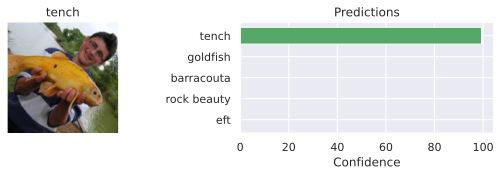

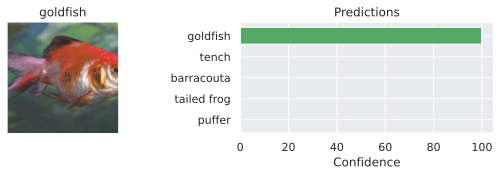

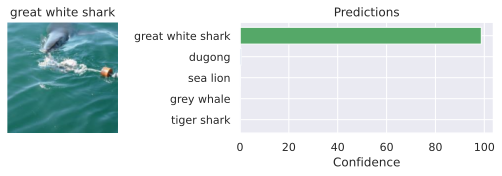

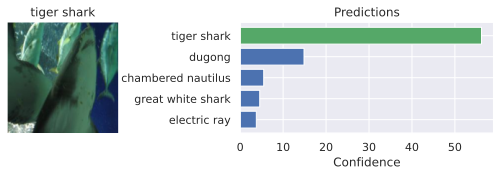

In [57]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

The bar plot on the right shows the top-5 predictions of the model with their class probabilities. We denote the class probabilities with "confidence" as it somewhat resembles how confident the network is that the image is of one specific class. Some of the images have a highly peaked probability distribution, and we would expect the model to be rather robust against noise for those. However, we will see below that this is not always the case. Note that all of the images are of fish because the data loader doesn't shuffle the dataset. Otherwise, we would get different images every time we run the notebook, which would make it hard to discuss the results on the static version.

### Adversarial Patches

Instead of changing every pixel by a little bit, we can also try to change a small part of the image into whatever values we would like. In other words, we will create a small image patch that covers a minor part of the original image but causes the model to confidentially predict a specific class we choose. This form of attack is an even bigger threat in real-world applications than FSGM. Imagine a network in an autonomous car that receives a live image from a camera. Another driver could print out a specific pattern and put it on the back of his/her vehicle to make the autonomous car believe that the car is actually a pedestrian. Meanwhile, humans would not notice it. [Tom Brown et al.](https://arxiv.org/pdf/1712.09665.pdf) proposed a way of learning such adversarial image patches robustly in 2017 and provided a short demonstration on [YouTube](https://youtu.be/i1sp4X57TL4). Interestingly, if you add a small picture of the target class (here *toaster*) to the original image, the model does not pick it up at all. A specifically designed patch, however, which only roughly looks like a toaster, can change the network's prediction instantaneously.

[![Adversarial patch in real world](https://img.youtube.com/vi/i1sp4X57TL4/0.jpg)](https://youtu.be/i1sp4X57TL4)

Let's take a closer look at how we can actually train such patches. We calculate gradients for the input, and update our adversarial input correspondingly. We do not calculate a gradient for every pixel. Instead, we replace parts of the input image with our patch and then calculate the gradients just for our patch. Secondly, we don't just do it for one image, but we want the patch to work with any possible image. Hence, we have a whole training loop where we train the patch using SGD. Lastly, image patches are usually designed to make the model predict a specific class, not just any other arbitrary class except the true label. For instance, we can try to create a patch for the class "toaster" and train the patch so that our pretrained model predicts the class "toaster" for any image with the patch in it.

[Brown et al.](https://arxiv.org/pdf/1712.09665.pdf) randomly rotated and scaled the patch during training before placing it at a random position in an input image. This makes the patch more robust to small changes and is necessary if we want to fool a neural network in a real-world application.

This tutorial only shows how to make the patch robust to the location in the image.

Here is where you could:
* Randomly rotate patch
* Randomly scale the patch
* Improve random location of patch in the image

In [58]:
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

The patch itself will be an `nn.Parameter` whose values are in the range between $-\infty$ and $\infty$. Images are, however, naturally limited in their range, and thus we write a small function that maps the parameter into the image value range of ImageNet:

In [59]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

Before looking at the actual training code, we can write a small evaluation function. We evaluate the success of a patch by how many times we were able to fool the network into predicting our target class. A simple function for this is implemented below.

In [60]:
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

Finally, we can look at the training loop. Given a model to fool, a target class to design the patch for, and a size $k$ of the patch in the number of pixels, we first start by creating a parameter of size $3\times k\times k$. These are the only parameters we will train, and the network itself remains untouched. We use a simple SGD optimizer with momentum to minimize the classification loss of the model given the patch in the image. While we first start with a very high loss due to the good initial performance of the network, the loss quickly decreases once we start changing the patch. In the end, the patch will represent patterns that are characteristic of the class. For instance, if we would want the model to predict a "goldfish" in every image, we would expect the pattern to look somewhat like a goldfish. Over the iterations, the model finetunes the pattern and, hopefully, achieves a high fooling accuracy.

In [61]:
def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

To get some experience with what to expect from an adversarial patch attack, we want to train multiple patches for different classes. As the training of a patch can take one or two minutes on a GPU, we have provided a couple of pre-trained patches including their results on the full dataset. The results are saved in a JSON file, which is loaded below.

In [62]:
# Load evaluation results of the pretrained patches
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)

# If you train new patches, you can save the results via calling this function
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t
                                   for t in patch_dict[cname][psize]["results"]]
                           for psize in patch_dict[cname]}
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

Additionally, we implement a function to train and evaluate patches for a list of classes and patch sizes. The pretrained patches include the classes *toaster*, *goldfish*, *school bus*, *lipstick*, and *pineapple*. We chose the classes arbitrarily to cover multiple domains (animals, vehicles, fruits, devices, etc.). We trained each class for three different patch sizes: $32\times32$ pixels, $48\times48$ pixels, and $64\times64$ pixels. We can load them in the two cells below.

In [63]:
def get_patches(class_names, patch_sizes):
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            # Load evaluation results if exist, otherwise manually evaluate the patch
            if name in json_results:
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(pretrained_model, patch, data_loader, target_class=c)

            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }

    return result_dict

Feel free to add any additional classes and/or patch sizes.

# Night Snake Patches

**Add `night snake` as adversarial class name, and train accordingly.**

In [ ]:
class_names = ['school bus', 'lipstick', 'night snake']
patch_sizes = [32, 64]

patch_dict = get_patches(class_names, patch_sizes)
# save_results(patch_dict) # Uncomment if you add new class names and want to save the new results

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
save_results(patch_dict)

Before looking at the quantitative results, we can actually visualize the patches.

** View additional patches result**

In [ ]:
def show_patches():
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*2.2, len(patch_sizes)*2.2))
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            patch = (torch.tanh(patch) + 1) / 2 # Parameter to pixel values
            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, a_min=0.0, a_max=1.0)
            ax[p_idx][c_idx].imshow(patch)
            ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
            ax[p_idx][c_idx].axis('off')
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
show_patches()

We can see a clear difference between patches of different classes and sizes. In the smallest size, $32\times 32$ pixels, some of the patches clearly resemble their class. For instance, the goldfish patch clearly shows a goldfish. The eye and the color are very characteristic of the class. Overall, the patches with $32$ pixels have very strong colors that are typical for their class (yellow school bus, pink lipstick, greenish pineapple). The larger the patch becomes, the more stretched the pattern becomes. For the goldfish, we can still spot regions that might represent eyes and the characteristic orange color, but it is not clearly a single fish anymore. For the pineapple, we might interpret the top part of the image as the leaves of pineapple fruit, but it is more abstract than our small patches. Nevertheless, we can easily spot the alignment of the patch to class, even on the largest scale.

Let's now look at the quantitative results.

In [ ]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [ ]:
import tabulate
from IPython.display import display, HTML

def show_table(top_1=True):
    i = 0 if top_1 else 1
    table = [[name] + [f"{(100.0 * patch_dict[name][psize]['results'][i]):4.2f}%" for psize in patch_sizes]
             for name in class_names]
    display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Class name"] + [f"Patch size {psize}x{psize}" for psize in patch_sizes])))

First, we will create a table of top-1 accuracy, meaning that how many images have been classified with the target class as highest prediction?

In [ ]:
show_table(top_1=True)

The clear trend, that we would also have expected, is that the larger the patch, the easier it is to fool the model. For the largest patch size of $64\times 64$, we are able to fool the model on almost all images, despite the patch covering only 8% of the image. The smallest patch actually covers 2% of the image, which is almost neglectable. Still, the fooling accuracy is quite remarkable. A large variation can be however seen across classes. While *school bus* and *pineapple* seem to be classes that were easily predicted, *toaster* and *lipstick* seem to be much harder for creating a patch. It is hard to intuitively explain why our patches underperform on those classes. Nonetheless, a fooling accuracy of >40% is still very good for such a tiny patch.

Let's also take a look at the top-5 accuracy:

In [ ]:
show_table(top_1=False)

We see a very similar pattern across classes and patch sizes. The patch size $64$ obtains >99.7% top-5 accuracy for any class, showing that we can almost fool the network on any image. A top-5 accuracy of >70% for the hard classes and small patches is still impressive and shows how vulnerable deep CNNs are to such attacks.

Finally, let's create some example visualizations of the patch attack in action.

In [ ]:
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

In [ ]:
perform_patch_attack(patch_dict['night snake'][32]['patch'])

The tiny goldfish patch can change all of the predictions to "goldfish" as top class. Note that the patch attacks work especially well if the input image is semantically similar to the target class (e.g. a fish and the target class "goldfish" works better than an airplane image with that patch). Nevertheless, we can also let the network predict semantically dis-similar classes by using a larger patch:

In [ ]:
perform_patch_attack(patch_dict['night snake'][64]['patch'])

**As we could see that from the test result, in 32x32 patch, the algorithm is not easy to fool. But when the patches get larger to 64x64, all of the images were predicted "night snake" with the highest confidence.**